In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Ridge,LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

In this Jupyter notebook, we test the functions used in the project. 

The input consists of two variables, each containing 500 random points between 0 and 1. 

The true function is a first-degree polynomial with a non-zero intercept, and there are no sources of noise. 

By applying different algorithms, we expect the estimated first-degree function to have an MSE of 0 and an R Squared of 1, since there are no sources of error in the true function and both bias and variance are zero as well.

The parameters in the OLS regression should match the true function. For Ridge and Lasso regression the parameters might be slightly lower than the real ones due to the penalty term introduced in the loss function. 

Lastly, we tested the code where cross-validation (CV) was applied, finding results consistent with the previous methods.



# OLS scikit

In [212]:
# Make data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

def ols(X_train, X_val, z_train, z_val, start_degree, degree, plot = False):
    ''' 
    Performs Ordinary Least Squares (OLS) regression with polynomial feature expansion.
    For polynomial degrees ranging from `start_degree` to `degree`
    Model with the lowest validation MSE is selected as the "best model". 
    
    Input Parameters:
    X_train :The training feature matrix.
    X_val :The validation feature matrix.
    z_train :The target vector for training.
    z_val :The target vector for validation.
    start_degree :The starting polynomial degree.
    degree :The maximum polynomial degree to evaluate.
    plot :Whether or not to plot beta coefficients, MSE, and R² for training and validation data.
    '''
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    betas = []
    best_model = []
    
    for i in range(start_degree, degree + 1):
       
        # Generate polynomial features for each degree
        poly = PolynomialFeatures(degree=i)

        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        # Scaling Data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        linreg = LinearRegression()
        model = linreg.fit(X_train_poly,z_train)

        # TRAIN - Calculate MSE for training data
        z_hat_train = model.predict(X_train_poly)
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))

        # Validation - Calculate MSE for testing data
        z_hat_val = model.predict(X_val_poly)
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))

        if mean_squared_error(z_val, z_hat_val) == min(mse_val): # Saving parameters of the best model
            best_model = model.coef_  

        #print(f"model having {i} degree has {mean_squared_error(z_val, z_hat_val)} mse")

    if plot==True:
    
        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train",marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation",marker='o')
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.grid(True)
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(1, degree + 1)], R2_train, label="Train",marker='o')
        plt.plot([i for i in range(1, degree + 1)], R2_val, label="Validation",marker='o')
        plt.xlabel("Degree")
        plt.ylabel("R squared")
        plt.title("R squared for training and validation data")
        plt.grid(True)
        plt.legend()
        plt.show()

    # return degree of the best model
    print(f"The best model has {mse_val.index(min(mse_val)) + start_degree} degree(s) having an MSE of {round(min(mse_val),4)}.")
    return best_model
    
start_degree= 1
degree = 3 # metti anche i grafici con degree 50 per far vedere che il comportamento è giusto

result_ols_scikit = ols(X_train, X_val, z_train, z_val, start_degree, degree)

The best model has 1 degree(s) having an MSE of 0.0.


In [213]:
result_ols_scikit

array([0., 3., 4.])

# OLS by hand

In [173]:
# Make data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)


# Function to compute the pseudoinverse using SVD
def SVDinv(A, tol=1e-10):
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    # Apply threshold to avoid dividing by very small singular values
    s_inv = np.array([1/si if si > tol else 0 for si in s])
    # Reconstruct the pseudoinverse
    return (VT.T @ np.diag(s_inv) @ U.T)
 
def ols(X_train, X_val, z_train, z_val,start_degree, degree, plot = False):  
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    betas = []
    best_model = []

    for i in range(start_degree, degree + 1):
       
        # Generate polynomial features for each degree
        poly = PolynomialFeatures(degree=i)

        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering data 
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        # Fit the model with the transformed features
        #beta = np.dot(np.dot(np.linalg.inv(np.dot(X_train_poly.T,X_train_poly)),X_train_poly.T),z_train)
        beta = SVDinv(X_train_poly) @ z_train
        betas.append(beta)

        # TRAIN - Calculate MSE for training data
        z_hat_train = np.dot(X_train_poly,beta)
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))

        # VALIDATION - Calculate MSE for validation data
        z_hat_val = np.dot(X_val_poly,beta)
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))

        if mean_squared_error(z_val, z_hat_val) == min(mse_val):
            best_model = beta
            

    if plot==True:
    
        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train")
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(1, degree + 1)], R2_train, label="Train")
        plt.plot([i for i in range(1, degree + 1)], R2_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("R squared")
        plt.title("R squared for training and validation data")
        plt.legend()
        plt.show()


    # return degree of the best model
    print(f"The best model has {mse_val.index(min(mse_val)) + start_degree} degree(s) having an MSE of {round(min(mse_val),4)}.")
    return best_model,min(mse_val)

degree = 3
start_degree = 1

result_ols = ols(X_train, X_val, z_train, z_val, start_degree, degree)

The best model has 1 degree(s) having an MSE of 0.0.


In [174]:
# OPTIMIZED PARAMETERS
result_ols[0]

array([5.48768834, 3.        , 4.        ])

# OLS without centering the data
We applied the same function without centering the data to demonstrate that the value of the estimated intercept matches the one in the real function.

In [128]:
# Make data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

# Function to compute the pseudoinverse using SVD
def SVDinv(A):
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    D = np.zeros((len(U),len(VT)))
    D = np.diag(s)
    UT = np.transpose(U); V = np.transpose(VT); invD = np.linalg.inv(D)
    return np.matmul(V,np.matmul(invD,UT))
 
def ols(X_train, X_val, z_train, z_val,start_degree, degree, plot = False):    
    mse_train = []
    mse_val = []

    R2_train = []
    R2_val = []

    betas = []

    best_model = []

    for i in range(start_degree, degree + 1):
       
        # Generate polynomial features for each degree
        poly = PolynomialFeatures(degree=i)

        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Fit the model with the transformed features
        beta = SVDinv(X_train_poly) @ z_train
        betas.append(beta)

        # TRAIN - Calculate MSE for training data
        z_hat_train = np.dot(X_train_poly,beta)
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))

        # VALIDATION - Calculate MSE for validation data
        z_hat_val = np.dot(X_val_poly,beta)
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))

        if mean_squared_error(z_val, z_hat_val) == min(mse_val):
            best_model = beta
            

    if plot==True:
    
        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train")
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(1, degree + 1)], R2_train, label="Train")
        plt.plot([i for i in range(1, degree + 1)], R2_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("R squared")
        plt.title("R squared for training and validation data")
        plt.legend()
        plt.show()


    # return degree of the best model
    print(f"The best model has {mse_val.index(min(mse_val)) + start_degree} degree(s) having an MSE of {round(min(mse_val),4)}.")
    return best_model,min(mse_val)

degree = 3
start_degree = 1

result_ols_nocentering= ols(X_train, X_val, z_train, z_val, start_degree, degree)

The best model has 1 degree(s) having an MSE of 0.0.


In [129]:
# OPTIMAL PARAMETERS
result_ols_nocentering[0]

array([2., 3., 4.])

# Ridge no intercept

### scikit

The best model with degree: 1 has a lambda:0.0001 and a MSE:1.3294311060191041e-08
The best model with degree: 2 has a lambda:0.0001 and a MSE:1.1161416969881724e-06
The best model with degree: 3 has a lambda:0.0001 and a MSE:0.00028474146757281134


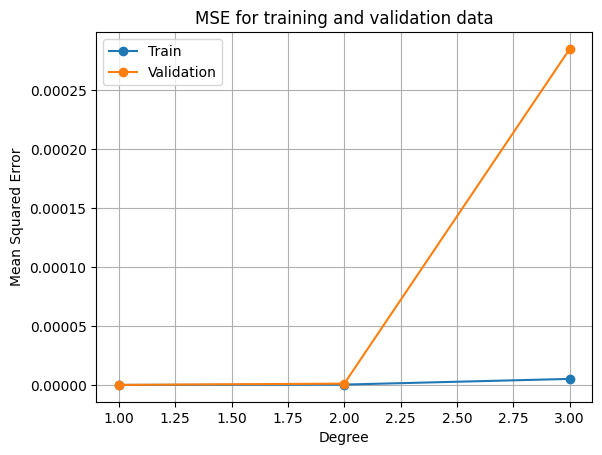

The best model overall, based on MSE performance, has a degree 1 and a MSE:0.0


In [243]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

def Ridge_noint(X_train,X_val,z_train,z_val,start_degree,degree, plot = False):
    
    mse_train = []
    mse_val = []
    best_lamb_mse= []
    betas= []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Scaling Data
        scaler = StandardScaler(with_std=False)
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_val_poly = scaler.transform(X_val_poly)
        
        # Removing the intercept
        X_train_poly = X_train_poly[:,1:]
        X_val_poly = X_val_poly[:,1:]
        
        result = lambda_ridge_noint(X_train_poly, X_val_poly,z_train,z_val)

        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        betas.append(result[3])
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        
        if mse_val[-1] == min(mse_val): # Saving the best model based on validation MSE
            best_model = result[3]


    if plot==True:

        # Complexity and MSE plot 
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train",marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation",marker='o')
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.grid(True)
        plt.show()
    
        
    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{round(mse_val[idx],4)}")
  
    return best_model
    
    
def lambda_ridge_noint(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    betas = []

    for lmb in lambdas:
        
        # Ridge regression
        ridge = Ridge(alpha=lmb, fit_intercept=False, max_iter = 10_000)
        model = ridge.fit(X_train_poly, z_train)
        
        # TRAIN - Calculate MSE for training data
        intercept = np.mean(z_train) - np.dot(np.mean(X_train_poly, axis=0), model.coef_) # Data is normalized so intercept = np.mean(z_train)
        z_hat_train = model.predict(X_train_poly) + intercept                             # Since np.mean(X_train_poly)==0 now the second term will be simplified
        mse_train.append(mean_squared_error(z_train, z_hat_train))

        # VALIDATION - Calculate MSE for validation data
        z_hat_val = model.predict(X_val_poly) + intercept
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        
        # Change this line to ensure intercept is a 1D array
        all_betas = np.concatenate([[intercept], model.coef_])  # Wrap intercept in a list
        betas.append(all_betas)
        
    idx = mse_val.index(min(mse_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], betas[idx]
    
start_degree= 1
degree= 3

ridge_noint_scikit = Ridge_noint(X_train,X_val,z_train,z_val,start_degree,degree, True)

In [244]:
ridge_noint_scikit

array([5.04602421, 2.99979827, 3.99975848])

### by hand

In [231]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

def Ridge_noint(X_train, X_val, z_train, z_val, start_degree, degree, plot=False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse = []
    best_lamb_R2 = []
    
    for i in range(start_degree, degree + 1):
        poly = PolynomialFeatures(degree=i) 
        
        # Transform the data into polynomial features
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Remove the intercept 
        X_train_poly = X_train_poly[:, 1:]
        X_val_poly = X_val_poly[:, 1:]

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_val_poly = scaler.transform(X_val_poly)

        # Finding best lambda for each degree
        result = lambda_ridge_noint(X_train_poly, X_val_poly, z_train, z_val)

        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda: {best_lamb_mse[-1]} and an MSE: {mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda: {best_lamb_R2[-1]} and R2: {R2_val[-1]}")

        # Saving the best model based on validation MSE
        if mse_val[-1] == min(mse_val):
            best_model = result[6]

    if plot:
        # Plot MSE for training and validation data
        plt.plot(range(start_degree, degree + 1), mse_train, label="Train")
        plt.plot(range(start_degree, degree + 1), mse_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.show()
    
        # Plot R2 for training and validation data
        plt.plot(range(start_degree, degree + 1), R2_train, label="Train")
        plt.plot(range(start_degree, degree + 1), R2_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("R squared")
        plt.title("R squared for training and validation data")
        plt.legend()
        plt.show()

    # Find the model with the lowest validation MSE
    idx = mse_val.index(min(mse_val))
    print(f"The best model overall, based on MSE performance, has a degree {idx + start_degree} and an MSE: {mse_val[idx]}")
    
    # Find the model with the highest validation R2
    idx_R2 = R2_val.index(max(R2_val))
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2 + start_degree} and an R2: {R2_val[idx_R2]}")

    return best_model, mse_val[idx]
    
    
def lambda_ridge_noint(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001, 0.001, 0.01, 0.1, 1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    params = []

    for lmb in lambdas:
        
        # Compute the Ridge regression coefficients (betas)
        r_beta = np.linalg.inv(X_train_poly.T @ X_train_poly + lmb * np.identity(X_train_poly.shape[1])) @ X_train_poly.T @ z_train
        
        # Compute the intercept
        intercept = np.array([np.mean(z_train) - (np.mean(X_train_poly, axis=0) @ r_beta)])
        betas = np.concatenate([intercept, r_beta])
        params.append(betas)
        
        # Training predictions
        z_hat_train = (X_train_poly @ r_beta) + intercept
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
    
        # Validation predictions
        z_hat_val = (X_val_poly @ r_beta) + intercept
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))

    # Find the index of the best lambda for MSE and R2
    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], params[idx]


degree = 3
start_degree = 1

result_ridge = Ridge_noint(X_train,X_val,z_train,z_val,start_degree,degree)

The best model with degree: 1 has a lambda: 0.0001 and an MSE: 1.3294311060027881e-08
The best model with degree: 1 has a lambda: 0.0001 and R2: 0.9999999959149597
The best model with degree: 2 has a lambda: 0.0001 and an MSE: 1.1161416969950577e-06
The best model with degree: 2 has a lambda: 0.0001 and R2: 0.9999996570349705
The best model with degree: 3 has a lambda: 0.0001 and an MSE: 0.00028474146755990597
The best model with degree: 3 has a lambda: 0.0001 and R2: 0.9999125054049331
The best model overall, based on MSE performance, has a degree 1 and an MSE: 1.3294311060027881e-08
The best model overall, based on R2 performance, has a degree 1 and an R2: 0.9999999959149597


In [232]:
# OPTIMIZED PARAMETERS
result_ridge

(array([5.04602421, 2.99979827, 3.99975848]),
 np.float64(1.3294311060027881e-08))

# Lasso 

In [229]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

def Lasso_noint(X_train,X_val,z_train,z_val,start_degree, degree, plot = False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse= []
    best_lamb_R2= []
    
    for i in range(start_degree,degree+1):
        
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        #Removing the intercept
        X_train_poly = X_train_poly[:,1:]
        X_val_poly = X_val_poly[:,1:]

        # Scale the polynomial data
        scaler = StandardScaler(with_std=False)
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_val_poly = scaler.transform(X_val_poly)
        
        result = lambda_lasso_noint(X_train_poly, X_val_poly,z_train,z_val)
        # print(result)
        
        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda:{best_lamb_R2[-1]} and R2:{R2_val[-1]}")
        
        if mse_val[-1] == min(mse_val):
            best_model = result[6]

    if plot==True:

        # Complexity and MSE plot
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train")
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for training and validation data")
        plt.legend()
        plt.show()

        # Complexity and R2 plot
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train")
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation")
        plt.xlabel("Degree")
        plt.ylabel("R squared")
        plt.title("R squared for training and validation data")
        plt.legend()
        plt.show()

    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{mse_val[idx]}")
    
    idx_R2 = R2_val.index(max(R2_val)) 
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2+start_degree} and a R2:{R2_val[idx_R2]}")

    return best_model,mse_val[idx]


def lambda_lasso_noint(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    params = []
    
    for lmb in lambdas:
        
        # train model
        model = linear_model.Lasso(lmb,max_iter=10000000, fit_intercept = False) 
        
        # fit model
        model.fit(X_train_poly, z_train)

        # Intercept
        intercept = np.array([np.mean(z_train)- (np.mean(X_train_poly,axis = 0) @ model.coef_)])
        betas = np.concatenate([intercept, model.coef_])
        params.append(betas)
        
        # Train
        z_hat_train = model.predict(X_train_poly) + intercept
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
        
        # Validation
        z_hat_val = model.predict(X_val_poly) + intercept
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))
    
    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], params[idx]

degree = 3
start_degree = 1

result_lasso = Lasso_noint(X_train,X_val,z_train,z_val,start_degree, degree)

The best model with degree: 1 has a lambda:0.0001 and a MSE:3.2856656641655563e-07
The best model with degree: 1 has a lambda:0.0001 and R2:0.999999899038946
The best model with degree: 2 has a lambda:0.0001 and a MSE:6.721622089809136e-07
The best model with degree: 2 has a lambda:0.0001 and R2:0.9999997934597977
The best model with degree: 3 has a lambda:0.0001 and a MSE:4.053380918493483e-07
The best model with degree: 3 has a lambda:0.0001 and R2:0.9999998754487974
The best model overall, based on MSE performance, has a degree 1 and a MSE:3.2856656641655563e-07
The best model overall, based on R2 performance, has a degree 1 and a R2:0.999999899038946


In [230]:
# OPTIMIZED PARAMETERS
result_lasso[0]

array([5.04602421, 2.99881136, 3.99900826])

# OLS Botstrap

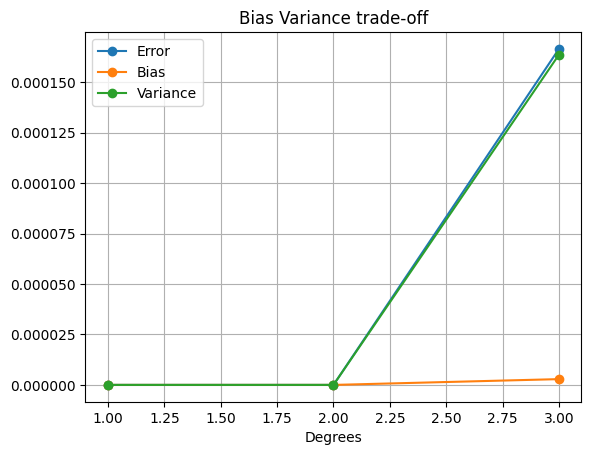

The best model has 1 degree(s) with an MSE of 0.0.


In [245]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.5, random_state=32)

def ols_bootstrap(X_train, X_val, z_train, z_val, start_degree, degree, n_boostraps, plot=False):

    # z_val needs to have a column for dimensionality problems
    z_val = z_val[:, np.newaxis]

    # Error, bias e variance
    error = np.zeros(degree)
    bias = np.zeros(degree)
    variance = np.zeros(degree)

    for d in range(start_degree, degree + 1):
        # New features
        poly = PolynomialFeatures(degree=d)

        # Adding new features
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        # Creating a model
        poly_model = LinearRegression(fit_intercept=False)

        # Bootstrap
        z_pred = np.empty((z_val.shape[0], n_boostraps))
        
        for i in range(n_boostraps):
            X_resampled, z_resampled = resample(X_train_poly, z_train)
            z_pred[:, i] = poly_model.fit(X_resampled, z_resampled).predict(X_val_poly).ravel()

        # Computation of errore, bias e variance for each degree
        error[d - start_degree] = np.mean(np.mean((z_val - z_pred) ** 2, axis=1, keepdims=True))
        bias[d - start_degree] = np.mean((z_val - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
        variance[d - start_degree] = np.mean(np.var(z_pred, axis=1, keepdims=True))

        if error[d - start_degree] == np.min(error[error != 0]):
            best_model = poly_model

    # Plot 
    if plot:
        plt.plot([i for i in range(start_degree, degree + 1)], error, label='Error', marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], bias, label='Bias', marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], variance, label='Variance', marker='o')
        plt.xlabel("Degrees")
        plt.title("Bias Variance trade-off")
        plt.grid(True)
        plt.legend()
        plt.show()
        
    print(f"The best model has {np.argmin(error[error != 0]) + start_degree} degree(s) with an MSE of {round(np.min(error), 4)}.")
    return best_model

n_boostraps = 500
prova_bootstrap = ols_bootstrap(X_train, X_val, z_train, z_val, start_degree, degree, n_boostraps, True)

# OLS CV

In [246]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

def ols_CV(X_train, z_train, start_degree, degree, plot=False):
    
    folds = 5

    scores = np.zeros(degree)

    for d in range(start_degree, degree + 1):
        # New features
        poly = PolynomialFeatures(degree=d)

        # Adding new features
        X_train_poly = poly.fit_transform(X_train)

        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns

        # Creating a model
        poly_model = LinearRegression(fit_intercept=False)

        # Cross Validation
        cv_scores = cross_val_score(poly_model, X_train_poly, z_train, cv=folds, scoring="neg_mean_squared_error")
        scores[d - start_degree] = np.mean(-cv_scores)
        
    # Plot 
    if plot:
        plt.plot([i for i in range(start_degree, degree + 1)], scores, label='MSE', marker='o')
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title(f"MSE by {folds}-fold Cross Validation")
        plt.legend()
        plt.grid(True)
        plt.show()

    print(f"The best model has {np.argmin(scores) + start_degree} degree(s) with an MSE of {round(np.min(scores), 4)}.")
    
degree = 3
start_degree = 1

result_ols_cv = ols_CV(X_train,z_train,start_degree,degree)

The best model has 1 degree(s) with an MSE of 0.0.


# Ridge CV

In [204]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

def RidgeCV(X_train,z_train,start_degree,degree, plot = False):
    
    tot_scores = []
    best_lambda = []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns

        if plot:
            score = lambda_ridge_cv(X_train_poly,z_train,i,True)    
        else:
            score = lambda_ridge_cv(X_train_poly,z_train,i)
   
        tot_scores.append(score[0])
        best_lambda.append(score[1])

    if plot:
        # Complexity and MSE plot 
        plt.plot([i for i in range(start_degree, degree + 1)], tot_scores, label="Train")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for all degrees")
        plt.legend()
        plt.grid(True)
        plt.show()

    idx = tot_scores.index(min(tot_scores)) 
    print(f"The best model overall, based on MSE performance, has: a degree {idx+start_degree}, a MSE = {min(tot_scores)} and lambda = {best_lambda[idx]}")
        
    return idx+start_degree, min(tot_scores), best_lambda[idx]
    
def lambda_ridge_cv(X_train_poly, z_train, degree, plot = False):
    
    lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    scores = []
    folds = 5

    for lmb in lambdas:

        model = Ridge(alpha=lmb, fit_intercept = False)
        
        cv_scores = cross_val_score(model, X_train_poly, z_train, cv= folds, scoring = "neg_mean_squared_error")
        scores.append(np.mean(-cv_scores))

    if plot:
        # Plot MSE
        plt.plot([i for i in lambdas], scores, label = "MSE", marker='o')
        plt.xlabel("Lambda")
        plt.ylabel("Mean Squared Error")
        plt.title(f" degree = {degree}")
        plt.legend()
        plt.grid(True)
        plt.show()

    print(f"The best model with degree = {degree} has a lambda = {lambdas[np.argmin(scores)]} and a MSE = {np.min(scores)}")

    return np.min(scores),lambdas[np.argmin(scores)]

degree = 3
start_degree = 1

result_ridgecv = RidgeCV(X_train,z_train,start_degree,degree)

The best model with degree = 1 has a lambda = 1e-05 and a MSE = 3.77188842088381e-11
The best model with degree = 2 has a lambda = 1e-05 and a MSE = 7.855108517042266e-10
The best model with degree = 3 has a lambda = 1e-05 and a MSE = 1.2989958265069102e-08
The best model overall, based on MSE performance, has: a degree 1, a MSE = 3.77188842088381e-11 and lambda = 1e-05


# Lasso CV (no intercept)

In [205]:
# Make data
np.random.seed(67)
x = np.random.rand(50,1)
y = np.random.rand(50,1)

z = 2 +3*x +4*y 

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)


def LassoCV(X_train,z_train,start_degree,degree, plot = False):
    
    tot_scores = []
    best_lambda = []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        
        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns
 
        if plot:
            score = lambda_lasso_cv(X_train_poly,z_train,i,True)
        else:
            score = lambda_lasso_cv(X_train_poly,z_train,i)
        tot_scores.append(score[0])
        best_lambda.append(score[1])

    if plot:

        # Complexity and MSE plot 
        plt.plot([i for i in range(start_degree, degree + 1)], tot_scores, label="Train")
        plt.xlabel("Degree")
        plt.ylabel("Mean Squared Error")
        plt.title("MSE for all degrees")
        plt.legend()
        plt.grid(True)
        plt.show()
    

    idx = tot_scores.index(min(tot_scores)) 
    print(f"The best model overall, based on MSE performance, has: a degree {idx+start_degree}, a MSE = {min(tot_scores)} and lambda = {best_lambda[idx]}")

    return idx+start_degree, min(tot_scores), best_lambda[idx]
    
    
def lambda_lasso_cv(X_train_poly, z_train, degree, plot = False):
    
    lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    scores = []
    folds = 5

    for lmb in lambdas:

        model = Lasso(alpha=lmb,max_iter=10000, fit_intercept = False)
        
        cv_scores = cross_val_score(model, X_train_poly, z_train, cv= folds, scoring = "neg_mean_squared_error")
        scores.append(np.mean(-cv_scores))

    if plot:
        # Plot MSE
        plt.plot([i for i in lambdas], scores, label = "MSE", marker='o')
        plt.xlabel("Lambda")
        plt.ylabel("Mean Squared Error")
        plt.title(f" degree = {degree}")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    print(f"The best model with degree = {degree} has a lambda = {lambdas[np.argmin(scores)]} and a MSE = {np.min(scores)}")

    return np.min(scores),lambdas[np.argmin(scores)]


degree = 3
start_degree = 1

result_lasso_cv = LassoCV(X_train,z_train,start_degree,degree)

The best model with degree = 1 has a lambda = 1e-05 and a MSE = 1.960556154203168e-09
The best model with degree = 2 has a lambda = 1e-05 and a MSE = 1.5623165998245917e-07
The best model with degree = 3 has a lambda = 0.0001 and a MSE = 2.672745081829796e-07
The best model overall, based on MSE performance, has: a degree 1, a MSE = 1.960556154203168e-09 and lambda = 1e-05
